# Relationship between Area Unemployment and Enrollment at LRCCD: A Simple Linear Regression
## Disclaimer
This analysis uses only public data and is not meant to inform public policy or decision-making. The work shown below was deveoped for educational purposes. 

## Background and Purpose
The notion that measures of Economic Recession share a correlative relationship with Ca. Community College (CCC) enrollment is almost taken as granted in news, trade publications, and even among CCC faculty. See [here](https://calmatters.org/education/higher-education/college-beat-higher-education/2020/11/community-college-enrollment-drop/?) and [here](https://calmatters.org/education/higher-education/college-beat-higher-education/2020/11/community-college-enrollment-drop/?) for recent articles on this topic.

The purpose of this analysis is to understand more about the relationship between the local unemployment rate and enrollment at an individual CCC district, Los Rios Community College District (LRCCD). 

## Methodology
A simple linear regression model is used to analyze the relationship between unemployment and enrollment. Time periods for both unemployment and enrollment data range from Fall 1992 to Fall 2019. Enrollment totals are for total FTES, Fall term only at all LRCCD colleges. Enrollment data was retrieved from CCCCO Data Mart. Unemployment rates are calculated using the mean (average) unemployment rates for June, July, August for Sacramento County. The rationale for the calulated unemployment rate is to create a prevailing unemployment rate for the Sacramento area that corresponds with Fall enrollment at LRCCD. Unemployment data was retrieved from Ca. EDD online data tool. 

## Limitations and Assumptions
There are several limitations to this study. First, only Fall term enrollment data is used in this analysis. The reason for this was to avoid analysis of "seasonal" data - techniques for which are out of scope for the present analysis. A potential limitation for the study is the use of a single economic indicator - unemployment - as representative of the overall economic "climate" for the region. More - this analysis is focused on a single CCC district and is not meant to be generalizable or represenative for the CCC system overall. A cursory analysis between Sacramento Co. unemployment calculations and the LRCCD service areas suggest overlap. An assumption for the model is that LRCCD students would be most impacted by the prevailing unemployment rate - as calculated in the model. 


## Regression Analysis
### Model Preparation

In [1]:
#import python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

%matplotlib inline

In [2]:
#data load and preparation

# load the data 
df = pd.read_csv('UnemLRCCD3-MoAvg.csv')

# set the data type to float
df = df.astype({'LRCCD FTE Enrollment': 'float', 
                'Sac. Co. Unemployment Rate (Jun-Aug Avg)': 'float'})

#drop month and year columns
df = df.drop(['Year ', 'Month'], axis=1)

#display first five rows of table
df.head()

,Academic Term,LRCCD FTE Enrollment,Sac. Co. Unemployment Rate (Jun-Aug Avg)
0,Fall 1992,53881.0,0.084333
1,Fall 1993,52293.0,0.086000
2,Fall 1994,51441.0,0.072333
3,Fall 1995,51953.0,0.071333
4,Fall 1996,54017.0,0.062000


In [3]:
#display data types for table columns
df.dtypes

Academic Term                                object
LRCCD FTE Enrollment                        float64
Sac. Co. Unemployment Rate (Jun-Aug Avg)    float64
dtype: object

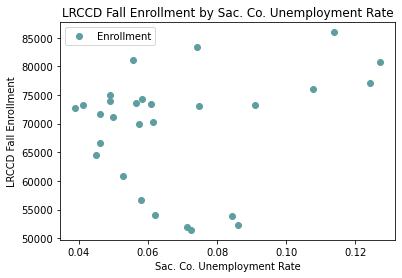

In [24]:
#create scatter plot for data
#define x & y
x = df['Sac. Co. Unemployment Rate (Jun-Aug Avg)']
y = df['LRCCD FTE Enrollment']

#create scatter plot
plt.plot(x,y, 'o', color = 'cadetblue', label='Enrollment')

#additional plot formatting
plt.title('LRCCD Fall Enrollment by Sac. Co. Unemployment Rate')
plt.xlabel("Sac. Co. Unemployment Rate")
plt.ylabel("LRCCD Fall Enrollment")
plt.legend()
plt.show()


The above scatterplot does not visually suggest a linear relationship between unemployment and enrollment. The analysis below seeks to statistically demonstrate the relationship between the two variables. Let's see what this data looks like if its charted out along a time-series (in this fall terms 1992-2019)

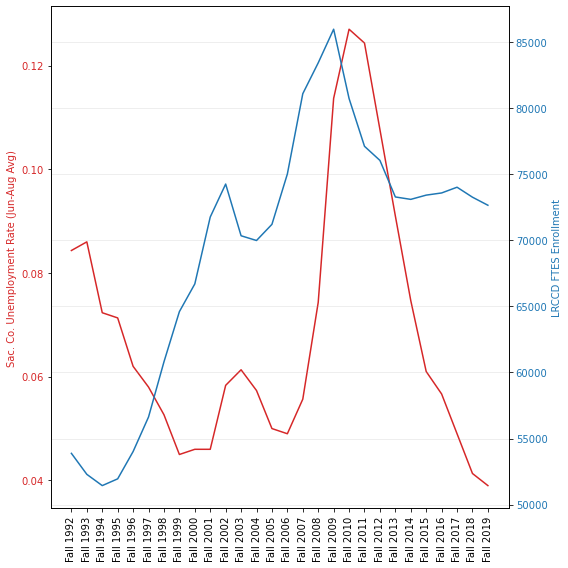

In [54]:
#here is an additional view of the data with both enrollment and unemployment rates on the y-axes
t = df['Academic Term']
data1 = df['Sac. Co. Unemployment Rate (Jun-Aug Avg)']
data2 = df['LRCCD FTE Enrollment']

fig, ax1 = plt.subplots(figsize = (8,8))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Sac. Co. Unemployment Rate (Jun-Aug Avg)', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params('x', labelrotation=90) 
#ax1.tick_params(labelrotation=45)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('LRCCD FTES Enrollment', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

The above figure is separate from our regression analysis, but does provide interesting (if - competing?) insights. First, in the period between 1992 and 1999 we can see unemployment and enrollment trending in opposite directions - very much contrary to the perception of the variables possessing a positive correlational relationship. Put another way - while both unemployment and enrollment are relatively low during this same period which fits to a perception of low unemployment/low enrollment, the opposite trend lines tell a different story altogether. The five-year period between 2006 and 2010 follow the conventional thinking - as the unemployment rate climbs steeply so, too, does enrollment. From the period of 2010 to 2019 unemployment drops precipitously, while enrollment dips then stabilizes. 

## Regression Modeling
In the cells below, I begin to explore the correlations between unemployment and enrollment and to build the regression model. 

In [52]:
#Measure the correlation
df.corr()

,LRCCD FTE Enrollment,Sac. Co. Unemployment Rate (Jun-Aug Avg)
LRCCD FTE Enrollment,1.000000,0.209243
Sac. Co. Unemployment Rate (Jun-Aug Avg),0.209243,1.000000


A correlation is a measurement of the strength of the relationship between two variables. In the present case we have a correlation of ~.209. This is considered to be a weak relationship. Despite this rather weak relationship, we will continue with our analysis beginning with a statistical summary of our dataset. 

In [6]:
#statistical summary of dataframe
df.describe()

,LRCCD FTE Enrollment,Sac. Co. Unemployment Rate (Jun-Aug Avg)
count,28.000000,28.000000
mean,69373.250000,0.068393
std,9957.796691,0.024788
min,51441.000000,0.039000
25%,63649.500000,0.049750
50%,72869.500000,0.059667
75%,74440.250000,0.077083
max,85962.000000,0.127000


In this statistical summary I am looking for outliers in our data. There is nothing here that raises any red flags or would give me any pause in moving forward with our analysis. 

Next we will look at a histogram for each columns of our data looking for visual cues for skewness of our data. Ideally, we would want to have normally distributed data. 

array([[<AxesSubplot:title={'center':'LRCCD FTE Enrollment'}>,
        <AxesSubplot:title={'center':'Sac. Co. Unemployment Rate (Jun-Aug Avg)'}>]],
      dtype=object)

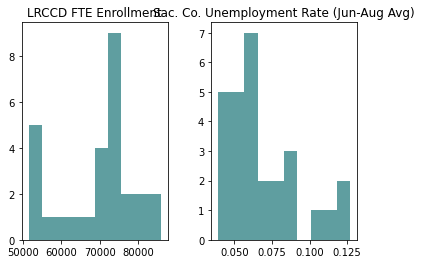

In [7]:
#checking for outliers and skewness by graphing histogram for each column of data
df.hist(grid = False, color = 'cadetblue')

Looking at the histograms above we can see that our measured attributes are not normally distributed. But, we want to attach some measures to that analysis by performing both Kurtosis and Skew tests. 

In [8]:
#calculate excess kurtosis using the fisher method.
enroll_kurtosis = kurtosis(df['LRCCD FTE Enrollment'], fisher = True)
unem_kurtosis = kurtosis(df['Sac. Co. Unemployment Rate (Jun-Aug Avg)'], fisher = True)

#calculate the skewness
enroll_skew = skew(df['LRCCD FTE Enrollment'])
unem_skew = skew(df['Sac. Co. Unemployment Rate (Jun-Aug Avg)'])

display("Enrolmment excess kurtosis: {:.2}".format(enroll_kurtosis))
display("Unemployment excess kurtosis: {:.2}".format(unem_kurtosis))

display("Enrollment skew: {:.2}".format(enroll_skew))
display("Unemployment skew: {:.2}".format(unem_skew))

'Enrolmment excess kurtosis: -0.71'

'Unemployment excess kurtosis: 0.18'

'Enrollment skew: -0.55'

'Unemployment skew: 1.1'

In [9]:
# perform a kurtosis test
display('Enrollment')
display(stats.kurtosistest(df['LRCCD FTE Enrollment']))
display('Unemployment')
display(stats.kurtosistest(df['Sac. Co. Unemployment Rate (Jun-Aug Avg)']))

# perform a skew test
display('Enrollment')
display(stats.skewtest(df['LRCCD FTE Enrollment']))
display('Unemployment')
display(stats.skewtest(df['Sac. Co. Unemployment Rate (Jun-Aug Avg)']))

'Enrollment'

KurtosistestResult(statistic=-0.7156684819519029, pvalue=0.47419607677039743)

'Unemployment'

KurtosistestResult(statistic=0.7510440089081225, pvalue=0.4526261706497744)

'Enrollment'

SkewtestResult(statistic=-1.3426166801822097, pvalue=0.17939612641514358)

'Unemployment'

SkewtestResult(statistic=2.461101365426574, pvalue=0.01385112262478277)

## Building the Regression Model

In [10]:
#Building the model - Split the data
#define input and output variables (X&Y)
Y = df[['LRCCD FTE Enrollment']]
X = df[['Sac. Co. Unemployment Rate (Jun-Aug Avg)']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [55]:
#create a linear regression model object
regression_model = LinearRegression()

#pass through the X_train and y_train data set
regression_model.fit(X_train, y_train)

LinearRegression()

### Visualizing our regression model. 
Taking a look now at our plotted regression model - the regression line is very underwhelming. A line approaching horizontal suggests there is no significant relationship between our two variables. Nevertheless, we will continue with our analysis. 

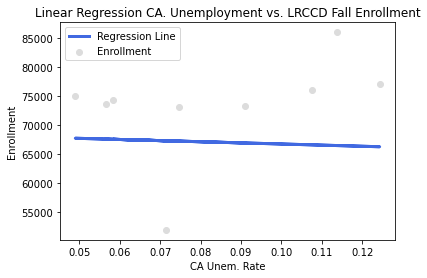

In [22]:
# Plot outputs
plt.scatter(X_test, y_test,  color='gainsboro', label = 'Enrollment')
plt.plot(X_test, y_predict, color='royalblue', linewidth = 3, linestyle= '-',label ='Regression Line')

plt.title("Linear Regression CA. Unemployment vs. LRCCD Fall Enrollment")
plt.xlabel("CA Unem. Rate")
plt.ylabel("Enrollment")
plt.legend()
plt.show()

## Establishing coefficient, intercept and regression equation

In [56]:
#capturing coefficient and intercept for model. 
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print("The coefficient for our model is {:.4}".format(coefficient))
print("The intercept for our model is {:.4}".format(intercept))


The coefficient for our model is -1.942e+04
The intercept for our model is 6.868e+04


Given our coefficient and intercept, we can now establish that our predictive line is: 
Predicted value for enrollment = -19,420(unemployment rate) + 68,680. 

Below we make some predictions by plugging in different values for the unemployment rate. 

In [57]:
#Making a single prediction
prediction = regression_model.predict([[0.020]])
predicted_value = prediction[0][0]
print("The predicted value is {:.4}".format(predicted_value))

The predicted value is 6.829e+04


In [14]:
#Making multiple predictions at once
# Get multiple predictions.
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[67577.2115723 ],
       [66470.36275832],
       [66263.23316865],
       [66586.87315979],
       [67726.08598065]])

## Model Evaluation
Although we have a working prediction model, we need to evaluate how useful it is. In order to do this, we will re-create the model, refit the model and run a series of tests. 

In [15]:
#Evaluating the Model
# define our intput
X2 = sm.add_constant(X)

# create a OLS model.
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

### Confidence Intervals
Confidence intervals can be interpreted as our "confidence" (in this case 95%) that our co-efficient falls between two intervals. In this case, the interval is rather large, leading me to be more concerned about the strength of our model. 

In [16]:
#Confidence Intervals. 
#Make some confidence intervals, 95% by default. 
est.conf_int()

,0,1
const,52128.703392,75120.244989
Sac. Co. Unemployment Rate (Jun-Aug Avg),-74298.550227,242408.965622


## Hypothesis Testing

Null Hypothesis: There is no relationship between area unemployment and LRCCD fall enrollment. 
    The coefficient equals 0.

Alternative Hypothesis: There IS a relationship between area unemployment and LRCCD fall enrollment. 
    The coefficient does not equal to 0.
    
If we reject the null, we are saying there is a relationship, and the coefficient does not equal 0.

If we fail to reject the null, we are saying there is no relationship, and the coefficient does equal 0.

The p-value represents the probability that the coefficient equals 0. We want a p-value that is less than 0.05 if it is we can reject the null hypothesis. 

In [17]:
# estimate the p-values.
est.pvalues

const                                       1.354660e-11
Sac. Co. Unemployment Rate (Jun-Aug Avg)    2.852424e-01
dtype: float64

The p-value represents the probability that the coefficient equals 0. We want a p-value that is less than 0.05. If it is we can reject the null hypothesis. In this case, the p-value for the oil_price coefficient is much lower than 0.05, so we can NOT reject the null hypothesis. 

In this case the p-value is approximately .285, thus we can not reject the null hypothesis - meaning there is NOT a relationship between unemployment and enrollment, as calculated in our model. 

It is clear at this point that our linear regression model is fatally flawed - but we will continue by assessing fitness of the model. 

## Model Fit

Mean Absolute Error (MAE): Is the mean of the absolute value of the errors. This metric gives an idea of magnitude but no idea of direction (too high or too low).

Mean Squared Error (MSE): Is the mean of the squared errors.MSE is more popular than MAE because MSE "punishes" more significant errors.

Root Mean Squared Error (RMSE): Is the square root of the mean of the squared errors. RMSE is even more favored because it allows us to interpret the output in y-units.

In [18]:
#Model Fitness

#mean squared error
model_mse = mean_squared_error(y_test, y_predict)

#mean absolute error
model_mae = mean_absolute_error (y_test, y_predict)

#root mean squared error
model_rmse = math.sqrt(model_mse)

print ("The Mean Squared Error (MSE) is {:.3}".format(model_mse))
print ("The Mean Absolute Error (MAE) is {:.3}".format(model_mae))
print ("The Root Mean Squared Error (rMSE) is {:.3}".format(model_rmse))

The Mean Squared Error (MSE) is 1.15e+08
The Mean Absolute Error (MAE) is 9.7e+03
The Root Mean Squared Error (rMSE) is 1.07e+04


In [19]:
#R-Squared
model_r2 = r2_score(y_test, y_predict)
print ("R2 is {:.3}".format(model_r2))

R2 is -0.606


In [20]:
#Create and print out a summary of the model
print(est.summary())

                             OLS Regression Results                             
Dep. Variable:     LRCCD FTE Enrollment   R-squared:                       0.044
Model:                              OLS   Adj. R-squared:                  0.007
Method:                   Least Squares   F-statistic:                     1.190
Date:                  Mon, 28 Dec 2020   Prob (F-statistic):              0.285
Time:                          18:29:43   Log-Likelihood:                -296.37
No. Observations:                    28   AIC:                             596.7
Df Residuals:                        26   BIC:                             599.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

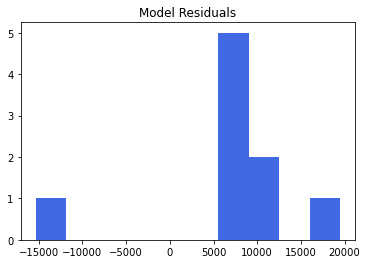

In [21]:
#Plot residuals
(y_test - y_predict).hist(grid=False, color = 'royalblue')
plt.title("Model Residuals")
plt.show()